In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import yfinance as yf
from sklearn.cluster import KMeans
from colorama import Fore, Style
import seaborn as sns
from sklearn.metrics import r2_score
sns.set(style='darkgrid')
import plotly.graph_objects as go
import pickle

import sys
sys.path.append('../src') 
from stock_strategy import stock_strategy, stock_regression

from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import fsolve

from kneed import KneeLocator

## Bear vs Bull Market?

In [56]:
df.head()

Price,date,close,ret,regime_dd,regime_sma,regime_ret,regime_tv
0,2020-01-02,273.532257,NaN,bull,bear,neutral,neutral
1,2020-01-03,271.534027,-0.007305,bull,bear,neutral,neutral
2,2020-01-06,272.551544,0.003747,bull,bear,neutral,neutral
3,2020-01-07,271.799927,-0.002758,bull,bear,neutral,neutral
4,2020-01-08,273.202271,0.005159,bull,bear,neutral,neutral


[*********************100%***********************]  1 of 1 completed


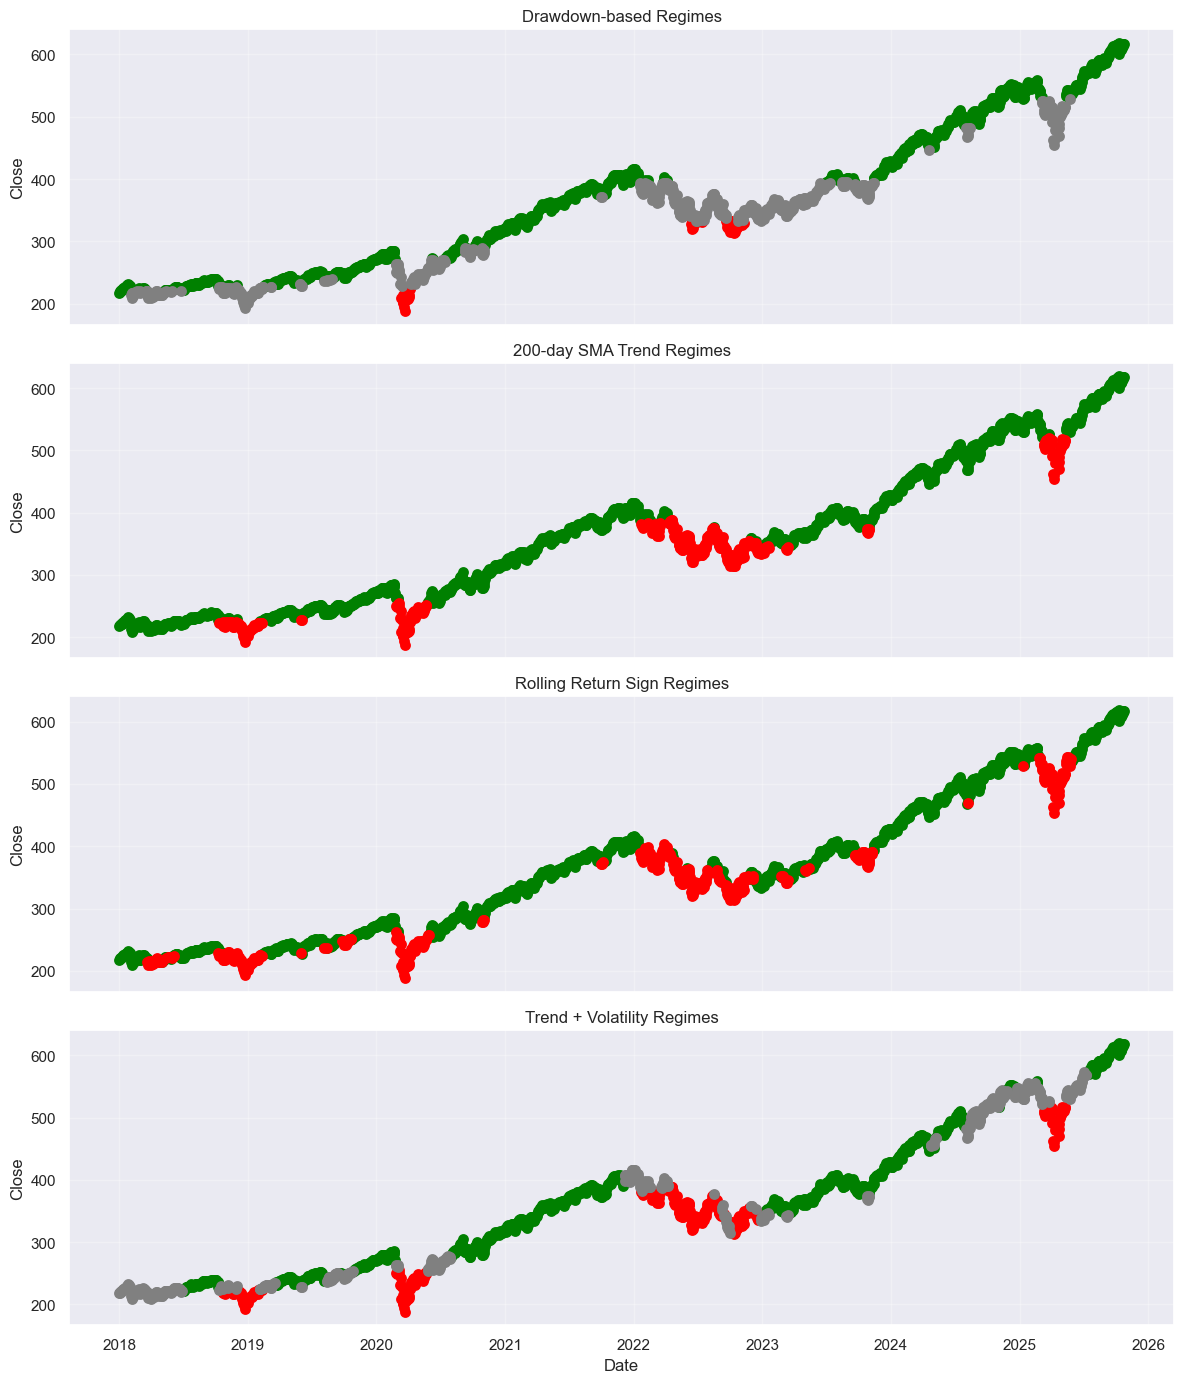

In [64]:
df = stock_strategy('voo', start='2017-01-01').df[['date','close']]

# === 1. Preprocess ===
df = df.sort_values("date")
df["date"] = pd.to_datetime(df["date"])
df["ret"] = df["close"].pct_change()

# Helper to plot regimes
def plot_regimes(ax, df, regime_col, title):
    colors = {"bull": "green", "bear": "red", "neutral": "gray"}
    for regime, color in colors.items():
        mask = df[regime_col] == regime
        ax.scatter(df.loc[mask, "date"], df.loc[mask, "close"], color=color, lw=1.8)
    ax.set_title(title)
    ax.set_ylabel("Close")
    ax.grid(True, alpha=0.3)

# === 2. (a) Drawdown threshold method ===
dd = df["close"] / df["close"].cummax() - 1
regime_dd = np.where(dd < -0.2, "bear",
             np.where(dd > -0.05, "bull", "neutral"))
df["regime_dd"] = regime_dd

# === 3. (b) Trend filter (200-day SMA) ===
sma200 = df["close"].rolling(200).mean()
regime_sma = np.where(df["close"] > sma200, "bull", np.where(df["close"] < sma200, "bear", "neutral"))
df["regime_sma"] = regime_sma

# === 4. (c) Rolling return sign (60-day) ===
roll_return = df["close"].pct_change(60)
regime_ret = np.where(roll_return > 0, "bull",
              np.where(roll_return < 0, "bear", "neutral"))
df["regime_ret"] = regime_ret

# === 5. (d) Trend + volatility combination ===
trend = df["close"] / sma200 - 1
vol = df["ret"].rolling(60).std()
vol_q60 = vol.rolling(252).quantile(0.6)
regime_tv = np.where((trend > 0) & (vol < vol_q60), "bull",
             np.where((trend < 0) & (vol > vol_q60), "bear", "neutral"))
df["regime_tv"] = regime_tv

# === 6. Plot all ===
fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)

df_plot = df[df['date']>='2018-01-01']
plot_regimes(axes[0], df_plot, "regime_dd", "Drawdown-based Regimes")
plot_regimes(axes[1], df_plot, "regime_sma", "200-day SMA Trend Regimes")
plot_regimes(axes[2], df_plot, "regime_ret", "Rolling Return Sign Regimes")
plot_regimes(axes[3], df_plot, "regime_tv", "Trend + Volatility Regimes")

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


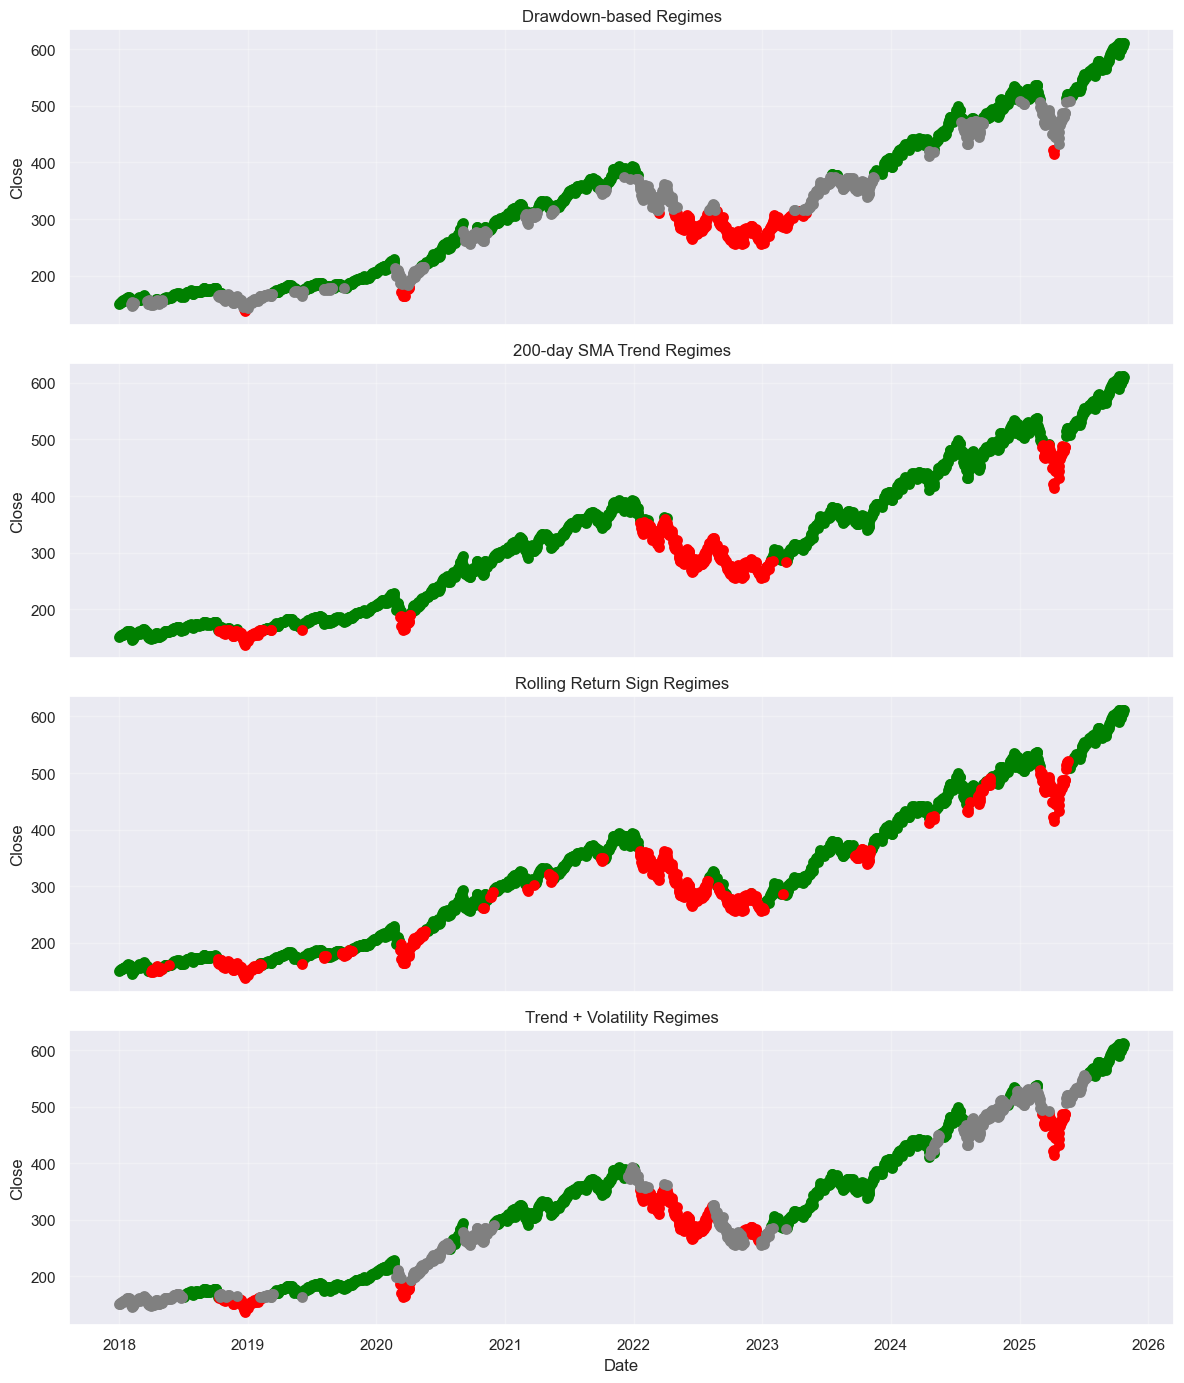

In [65]:
df = stock_strategy('qqq', start='2017-01-01').df[['date','close']]

# === 1. Preprocess ===
df = df.sort_values("date")
df["date"] = pd.to_datetime(df["date"])
df["ret"] = df["close"].pct_change()

# Helper to plot regimes
def plot_regimes(ax, df, regime_col, title):
    colors = {"bull": "green", "bear": "red", "neutral": "gray"}
    for regime, color in colors.items():
        mask = df[regime_col] == regime
        ax.scatter(df.loc[mask, "date"], df.loc[mask, "close"], color=color, lw=1.8)
    ax.set_title(title)
    ax.set_ylabel("Close")
    ax.grid(True, alpha=0.3)

# === 2. (a) Drawdown threshold method ===
dd = df["close"] / df["close"].cummax() - 1
regime_dd = np.where(dd < -0.2, "bear",
             np.where(dd > -0.05, "bull", "neutral"))
df["regime_dd"] = regime_dd

# === 3. (b) Trend filter (200-day SMA) ===
sma200 = df["close"].rolling(200).mean()
regime_sma = np.where(df["close"] > sma200, "bull", np.where(df["close"] < sma200, "bear", "neutral"))
df["regime_sma"] = regime_sma

# === 4. (c) Rolling return sign (60-day) ===
roll_return = df["close"].pct_change(60)
regime_ret = np.where(roll_return > 0, "bull",
              np.where(roll_return < 0, "bear", "neutral"))
df["regime_ret"] = regime_ret

# === 5. (d) Trend + volatility combination ===
trend = df["close"] / sma200 - 1
vol = df["ret"].rolling(60).std()
vol_q60 = vol.rolling(252).quantile(0.6)
regime_tv = np.where((trend > 0) & (vol < vol_q60), "bull",
             np.where((trend < 0) & (vol > vol_q60), "bear", "neutral"))
df["regime_tv"] = regime_tv

# === 6. Plot all ===
fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)

df_plot = df[df['date']>='2018-01-01']
plot_regimes(axes[0], df_plot, "regime_dd", "Drawdown-based Regimes")
plot_regimes(axes[1], df_plot, "regime_sma", "200-day SMA Trend Regimes")
plot_regimes(axes[2], df_plot, "regime_ret", "Rolling Return Sign Regimes")
plot_regimes(axes[3], df_plot, "regime_tv", "Trend + Volatility Regimes")

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

In [110]:
df_trade['Close'][0]

/var/folders/nb/2_t_pyss0gs6mwvk974rxmz80000gn/T/ipykernel_92161/3660801078.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_trade['Close'][0]


5.191920757293701

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/var/folders/nb/2_t_pyss0gs6mwvk974rxmz80000gn/T/ipykernel_92161/1331954370.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  peak_price = df_trade['Close'][0]


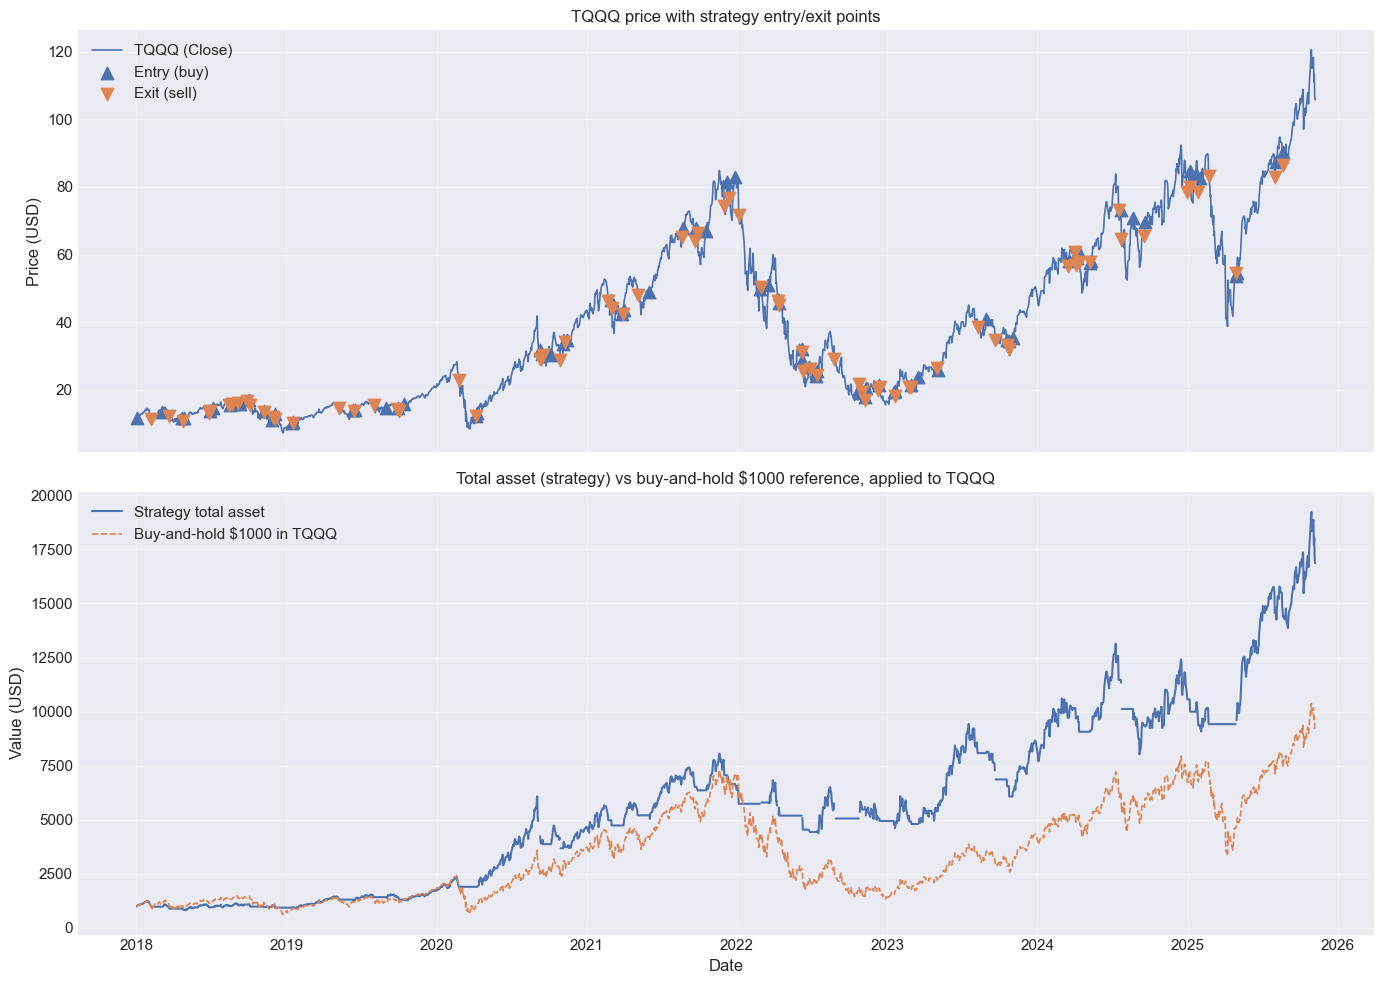

Strategy period: 2018-01-02 to 2025-11-07
Strategy: final value = $16861.59, CAGR = 43.34%, Max Drawdown = -45.67%
Buy-and-hold: final value = $9102.21, CAGR = 32.51%, Max Drawdown = -81.66%


In [118]:
plt.style.use('seaborn-v0_8-darkgrid')

# --- Parameters ---
strategy_start = pd.Timestamp("2018-01-01")
download_start = pd.Timestamp("2017-01-01")   # need at least 60 trading days earlier
symbols = {"signal_asset": "QQQ",
           "trade_asset": "TQQQ"}
initial_cash = 1000.0
rolling_days = 20

# --- 1) Download data ---
end_date = pd.Timestamp.today().normalize()  # or set a fixed date
# end_date = pd.Timestamp("2023-01-01")
print("Downloading price data...")
df_signal = yf.download(symbols["signal_asset"], start=download_start, end=end_date, prepost=True, auto_adjust=True).droplevel(level='Ticker', axis=1)
df_trade = yf.download(symbols["trade_asset"], start=download_start, end=end_date, prepost=True, auto_adjust=True).droplevel(level='Ticker', axis=1)

# Check existence
if df_signal.empty or df_trade.empty:
    raise RuntimeError("Failed to download data. Try again or provide CSVs.")

signal_asset = df_signal[['Close']].rename(columns={'Close': symbols["signal_asset"]})
trade_asset = df_trade[['Close']].rename(columns={'Close': symbols["trade_asset"]})

data = signal_asset.join(trade_asset, how='inner').dropna()
data.index.name = 'date'
data = data.sort_index()

# --- 2) compute rolling return (e.g. 60days) on signal_asset and generate bull/bear/neutral signal ---
data[f'{symbols["signal_asset"]}_ret{rolling_days}'] = data[f'{symbols["signal_asset"]}'].pct_change(periods=rolling_days)  # n-day simple pct change
# define signal: bull if >0, bear if <0, neutral if exactly 0 (very rare)
data[f'regime_{rolling_days}'] = np.where(data[f'{symbols["signal_asset"]}_ret{rolling_days}'] > 0, 'bull',
                            np.where(data[f'{symbols["signal_asset"]}_ret{rolling_days}'] < 0, 'bear', 'neutral'))

# restrict starting point to strategy_start
trade_df = data.loc[data.index >= strategy_start].copy()
if trade_df.empty:
    raise RuntimeError("No data from the strategy start date. Check dates.")

# --- 3) Backtest the described trading logic (no transaction costs, fractional shares allowed) ---
# state variables: cash, shares of trade_asset
cash = initial_cash
shares = 0.0
peak_price = df_trade['Close'][0]

# We'll record daily portfolio stats
trade_df['cash'] = np.nan
trade_df['shares'] = np.nan
trade_df['stock_value'] = np.nan
trade_df['total_asset'] = np.nan
trade_df['action'] = ''   # 'buy', 'sell', or ''

prev_position = 'cash'  # initially all cash

for date, row in trade_df.iterrows():
    price = row[f'{symbols["trade_asset"]}']
    signal = row[f'regime_{rolling_days}']

    # add stop-loss
    if shares > 0:
        peak_price = max(peak_price, price)
        if price <= 0.8 * peak_price:
            # Stop-loss trigger
            cash = shares * price
            shares = 0
            peak_price = price
            trade_df.at[date, 'action'] = 'sell'
            continue

    # on a bull and if there's cash, buy all into trade_asset
    if signal == 'bull':
        if cash > 0:
            shares = cash / price
            cash = 0.0
            trade_df.at[date, 'action'] = 'buy'
            prev_position = 'long'
        else:
            trade_df.at[date, 'action'] = ''
    # on bear and if holding trade_asset, sell all
    elif signal == 'bear':
        if shares > 0:
            cash = shares * price
            shares = 0.0
            trade_df.at[date, 'action'] = 'sell'
            prev_position = 'cash'
        else:
            trade_df.at[date, 'action'] = ''
    else:
        # neutral: do nothing
        trade_df.at[date, 'action'] = ''

    # record
    trade_df.at[date, 'cash'] = cash
    trade_df.at[date, 'shares'] = shares
    trade_df.at[date, 'stock_value'] = shares * price
    trade_df.at[date, 'total_asset'] = cash + shares * price

# If still holding shares after the last date, that's fine—total_asset uses last price.

# --- 4) Buy-and-hold reference: invest 1000 into trade_asset on strategy_start date ---
# find first available close on or after strategy_start
bnh = trade_df.copy()
first_date = bnh.index[0]
buy_price = bnh.iloc[0][f'{symbols["trade_asset"]}']
bnh['bnh_shares'] = initial_cash / buy_price
bnh['bnh_value'] = bnh['bnh_shares'] * bnh[f'{symbols["trade_asset"]}']

# --- 5) Identify entry and exit dates for plotting ---
entries = trade_df[trade_df['action'] == 'buy']
exits = trade_df[trade_df['action'] == 'sell']

# --- 6) Metrics: CAGR and Max Drawdown function ---
def CAGR(series, start_date, end_date):
    start_val = series.iloc[0]
    end_val = series.iloc[-1]
    days = (series.index[-1] - series.index[0]).days
    years = days / 365.25
    if start_val <= 0 or years <= 0:
        return np.nan
    return (end_val / start_val) ** (1 / years) - 1

def max_drawdown(series):
    # series is cumulative value series like total_asset
    cummax = series.cummax()
    drawdown = (series - cummax) / cummax
    maxdd = drawdown.min()
    # find start and end of max drawdown (optional)
    return float(maxdd)

# compute metrics
strat_series = trade_df['total_asset'].dropna()
bnh_series = bnh['bnh_value'].dropna()

strat_cagr = CAGR(strat_series, strat_series.index[0], strat_series.index[-1])
bnh_cagr = CAGR(bnh_series, bnh_series.index[0], bnh_series.index[-1])

strat_mdd = max_drawdown(strat_series)
bnh_mdd = max_drawdown(bnh_series)

# --- 7) Plots ---
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                         gridspec_kw={'height_ratios': [1, 1.05]})

# 1) trade_asset price with entry/exit markers
ax = axes[0]
ax.plot(trade_df.index, trade_df[f'{symbols["trade_asset"]}'], label=f'{symbols["trade_asset"]} (Close)', linewidth=1.2)
ax.scatter(entries.index, entries[f'{symbols["trade_asset"]}'], marker='^', s=80, label='Entry (buy)', zorder=5)
ax.scatter(exits.index, exits[f'{symbols["trade_asset"]}'], marker='v', s=80, label='Exit (sell)', zorder=5)
ax.set_title(f'{symbols["trade_asset"]} price with strategy entry/exit points')
ax.set_ylabel('Price (USD)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2) total asset vs buy-and-hold
ax = axes[1]
ax.plot(trade_df.index, trade_df['total_asset'], label='Strategy total asset', linewidth=1.5)
ax.plot(bnh.index, bnh['bnh_value'], label=f'Buy-and-hold $1000 in {symbols["trade_asset"]}', linewidth=1.2, linestyle='--')
ax.set_title(f'Total asset (strategy) vs buy-and-hold $1000 reference, applied to {symbols["trade_asset"]}')
ax.set_ylabel('Value (USD)')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 8) Print metrics ---
def format_pct(x):
    return "N/A" if pd.isna(x) else f"{x*100:.2f}%"

print("Strategy period:", trade_df.index[0].date(), "to", trade_df.index[-1].date())
print(f"Strategy: final value = ${strat_series.iloc[-1]:.2f}, CAGR = {format_pct(strat_cagr)}, Max Drawdown = {strat_mdd*100:.2f}%")
print(f"Buy-and-hold: final value = ${bnh_series.iloc[-1]:.2f}, CAGR = {format_pct(bnh_cagr)}, Max Drawdown = {bnh_mdd*100:.2f}%")

In [123]:
trade_df[trade_df['action']!=''].tail(10)

Price,QQQ,TQQQ,QQQ_ret20,regime_20,cash,shares,stock_value,total_asset,action
date,,,,,,,,,
2025-01-27,512.274475,78.611801,-0.029719,bear,9361.273366,0.000000,0.000000,9361.273366,sell
2025-01-30,521.081177,82.614906,0.014429,bull,0.000000,113.312159,9361.273366,9361.273366,buy
2025-02-21,524.099792,83.151291,-0.012316,bear,9422.052261,0.000000,0.000000,9422.052261,sell
2025-04-28,471.333618,53.618519,0.007400,bull,0.000000,175.723844,9422.052261,9422.052261,buy
2025-04-29,474.446533,54.664585,0.014096,bull,NaN,NaN,NaN,NaN,sell
2025-04-30,474.386658,54.674549,0.005860,bull,0.000000,175.691820,9605.871050,9605.871050,buy
2025-08-01,553.238647,82.840805,-0.004207,bear,14554.451826,0.000000,0.000000,14554.451826,sell
2025-08-04,563.446777,87.376472,0.021865,bull,0.000000,166.571749,14554.451826,14554.451826,buy
2025-08-21,562.627808,86.407394,-0.003062,bear,14393.030798,0.000000,0.000000,14393.030798,sell


In [119]:
strategy_ret = trade_df["total_asset"].pct_change().dropna()
bnh_ret = bnh["bnh_value"].pct_change().dropna()

risk_free = 0.05
trading_days = 252

rf_daily = risk_free / trading_days
excess_ret_strategy = strategy_ret - rf_daily
excess_ret_bnh = bnh_ret - rf_daily

sharpe_strategy = excess_ret_strategy.mean() / excess_ret_strategy.std() * np.sqrt(trading_days)
sharpe_bnh = excess_ret_bnh.mean() / excess_ret_bnh.std() * np.sqrt(trading_days)

print(f"Strategy Sharpe: {sharpe_strategy:.2f}")
print(f"Buy-and-hold Sharpe: {sharpe_bnh:.2f}")

Strategy Sharpe: 0.94
Buy-and-hold Sharpe: 0.69


/var/folders/nb/2_t_pyss0gs6mwvk974rxmz80000gn/T/ipykernel_92161/1903390170.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  strategy_ret = trade_df["total_asset"].pct_change().dropna()


### Swing strategy using Bollinger Band

In [49]:
def backtest_bollinger_swing_compound(
    signal_df,
    trade_df,
    init_cash=1000,
    boll_period=20,
    atr_period=20,
    k=2.0,
):
    """
    Cross-asset Bollinger swing backtest:
    Use signal_df to generate entry/exit conditions,
    and trade_df as the traded asset for execution.

    Example use case:
        signal_df = AAPL (smooth stock)
        trade_df = TQQQ (volatile counterpart)
    """

    sig = signal_df.copy().reset_index(drop=True)
    trd = trade_df.copy().reset_index(drop=True)

    # --- Merge on date ---
    df = pd.merge(sig, trd, on="date", suffixes=("_sig", "_trd"))

    # --- Signal calculations (on signal asset) ---
    df["MA5_sig"] = df["close_sig"].rolling(5).mean()
    df["MA10_sig"] = df["close_sig"].rolling(10).mean()
    df["MA20_sig"] = df["close_sig"].rolling(boll_period).mean()
    df["STD_sig"] = df["close_sig"].rolling(boll_period).std()

    df["upper_band_sig"] = df["MA20_sig"] + k * df["STD_sig"]
    df["lower_band_sig"] = df["MA20_sig"] - k * df["STD_sig"]

    # --- ATR (on traded asset) ---
    df["H-L_trd"] = df["high_trd"] - df["low_trd"]
    df["H-PC_trd"] = (df["high_trd"] - df["close_trd"].shift()).abs()
    df["L-PC_trd"] = (df["low_trd"] - df["close_trd"].shift()).abs()
    df["TR_trd"] = df[["H-L_trd", "H-PC_trd", "L-PC_trd"]].max(axis=1)
    df["ATR_trd"] = df["TR_trd"].rolling(atr_period).mean()

    # --- Bull market filter (signal asset) ---
    # df["bull_sig"] = (df["MA5_sig"] > df["MA10_sig"]) & (df["MA10_sig"] > df["MA20_sig"])
    df["bull_sig"] = (df["MA10_sig"] > df["MA20_sig"])

    # --- Initialize trading state ---
    cash = init_cash
    equity = init_cash
    in_position = False
    entry_price = None
    position_size = 0
    entry_date = None

    trades = []
    df["equity"] = np.nan

    for i in range(1, len(df)):
        prev = df.iloc[i - 1]
        curr = df.iloc[i]

        # Skip until indicators exist
        if np.isnan(prev["MA20_sig"]):
            df.loc[i, "equity"] = equity
            continue

        # --- Not in position ---
        if not in_position:
            if not prev["bull_sig"]:
                df.loc[i, "equity"] = equity
                continue

            # Entry condition (signal touches mid band)
            touched_ma = (prev["low_sig"] <= prev["MA20_sig"] <= prev["high_sig"])
            if touched_ma and cash > 0:
                entry_price = curr["open_trd"]
                position_size = cash / entry_price
                in_position = True
                entry_date = curr["date"]
                cash = 0
                equity = position_size * curr["close_trd"]

            df.loc[i, "equity"] = equity
            continue

        # --- In position ---
        else:
            # Define stop-loss using traded asset ATR
            stop_loss = max(prev["lower_band_sig"], entry_price - prev["ATR_trd"])

            exit_trade = False
            reason = None

            # Hybrid exit logic (on signal asset)
            if not prev["bull_sig"]:
                exit_trade = True
                reason = "bull_break"
            elif prev["close_sig"] < prev["MA5_sig"]:
                exit_trade = True
                reason = "momentum_break"
            elif prev["close_sig"] < prev["MA20_sig"]:
                exit_trade = True
                reason = "mean_revert_break"
            elif prev["low_trd"] <= stop_loss:
                exit_trade = True
                reason = "stop_loss"

            if exit_trade:
                exit_price = curr["open_trd"]
                exit_date = curr["date"]
                pnl = (exit_price - entry_price) * position_size
                cash = position_size * exit_price
                equity = cash

                trades.append({
                    "entry_date": entry_date,
                    "exit_date": exit_date,
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "shares": position_size,
                    "pnl": pnl,
                    "reason": reason,
                    "equity_after": equity
                })

                in_position = False
                entry_price = None
                position_size = 0
                entry_date = None
                df.loc[i, "equity"] = equity
                continue

            equity = position_size * curr["close_trd"]
            df.loc[i, "equity"] = equity

    # Close final equity
    if in_position:
        df.loc[len(df) - 1, "equity"] = position_size * df.iloc[-1]["close_trd"]

    trades_df = pd.DataFrame(trades)
    return df, trades_df


In [50]:
result_df, trades_df = backtest_bollinger_swing_compound(
    signal_df = stock_strategy('qqq', start="2025-01-01").df,
    trade_df = stock_strategy('tqqq', start="2025-01-01").df,
    init_cash=1000)
print(trades_df.head())
print(f"Final equity: {result_df['equity'].iloc[-1]:.2f}")
print(f"Total return: {(result_df['equity'].iloc[-1] / 1000 - 1):.2%}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  entry_date  exit_date  entry_price  exit_price     shares         pnl  \
0 2025-02-04 2025-02-05    80.369995   81.800375  12.442454   17.797444   
1 2025-02-13 2025-02-14    85.406145   88.217257  11.917145   33.500431   
2 2025-02-24 2025-02-25    83.936025   79.793856  12.524990  -51.880634   
3 2025-04-03 2025-04-04    52.233721   45.817830  19.133564 -122.758869   
4 2025-06-23 2025-06-24    72.457723   76.622077  12.098895   50.384085   

           reason  equity_after  
0       stop_loss   1017.797444  
1       stop_loss   1051.297875  
2  momentum_break    999.417241  
3      bull_break    876.658372  
4       stop_loss    927.042458  
Final equity: 938.92
Total return: -6.11%


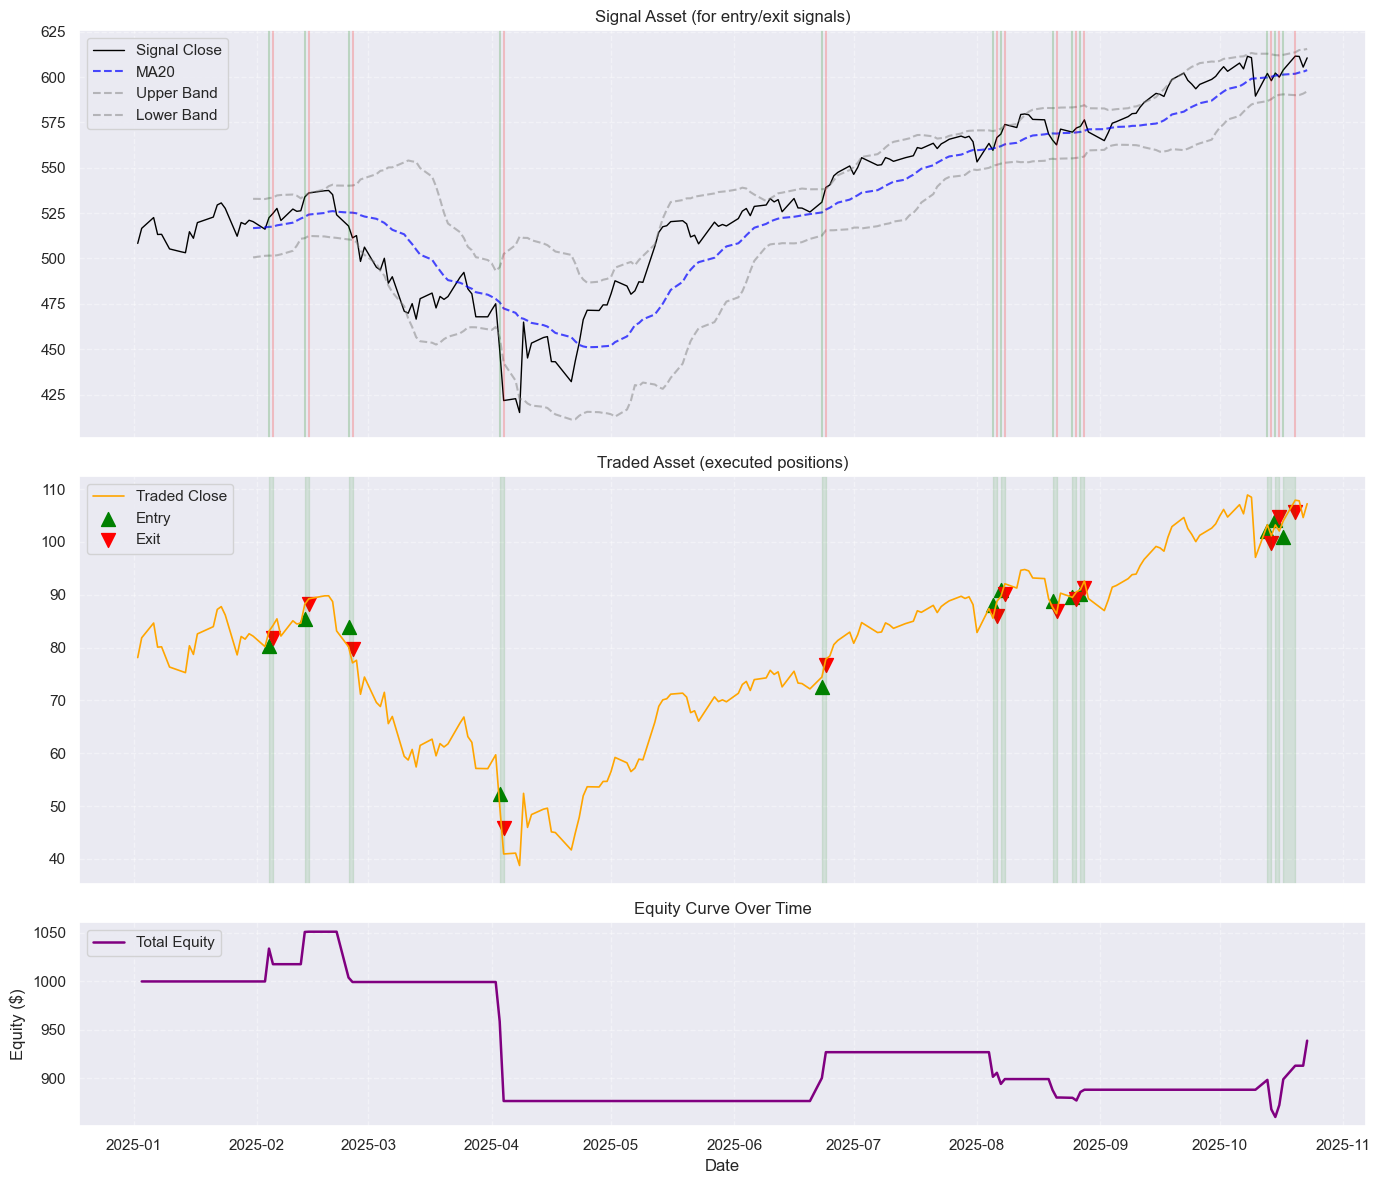

In [51]:
def plot_cross_signal_trades(result_df, trades_df):
    """
    Visualize cross-asset Bollinger strategy:
      1. Signal asset with Bollinger bands (signals generated here)
      2. Traded asset with actual entry/exit points
      3. Total equity over time
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True,
                             gridspec_kw={'height_ratios': [2, 2, 1]})
    ax_sig, ax_trd, ax_eq = axes

    # === 1️⃣ SIGNAL ASSET (for signals) ===
    ax_sig.plot(result_df['date'], result_df['close_sig'], label='Signal Close', color='black', linewidth=1)
    ax_sig.plot(result_df['date'], result_df['MA20_sig'], label='MA20', color='blue', linestyle='--', alpha=0.7)
    ax_sig.plot(result_df['date'], result_df['upper_band_sig'], label='Upper Band', color='gray', linestyle='--', alpha=0.5)
    ax_sig.plot(result_df['date'], result_df['lower_band_sig'], label='Lower Band', color='gray', linestyle='--', alpha=0.5)

    ax_sig.set_title("Signal Asset (for entry/exit signals)")
    ax_sig.legend(loc='upper left')
    ax_sig.grid(True, linestyle='--', alpha=0.4)

    # Mark entry/exit points (on signal asset)
    for _, t in trades_df.iterrows():
        ax_sig.axvline(pd.to_datetime(t['entry_date']), color='green', alpha=0.2)
        ax_sig.axvline(pd.to_datetime(t['exit_date']), color='red', alpha=0.2)

    # === 2️⃣ TRADED ASSET (actual executed trades) ===
    ax_trd.plot(result_df['date'], result_df['close_trd'], label='Traded Close', color='orange', linewidth=1.2)
    # ax_trd.plot(result_df['date'], result_df['MA20_sig'], color='blue', linestyle='--', alpha=0.3, label='Signal MA20')

    # Mark actual entry / exit points
    ax_trd.scatter(trades_df['entry_date'], trades_df['entry_price'],
                   color='green', marker='^', s=100, label='Entry')
    ax_trd.scatter(trades_df['exit_date'], trades_df['exit_price'],
                   color='red', marker='v', s=100, label='Exit')

    ax_trd.set_title("Traded Asset (executed positions)")
    ax_trd.legend(loc='upper left')
    ax_trd.grid(True, linestyle='--', alpha=0.4)

    # Optionally, highlight in-position periods
    for _, t in trades_df.iterrows():
        start, end = pd.to_datetime(t['entry_date']), pd.to_datetime(t['exit_date'])
        ax_trd.axvspan(start, end, color='green', alpha=0.1)

    # === 3️⃣ EQUITY CURVE ===
    ax_eq.plot(result_df['date'], result_df['equity'], label='Total Equity', color='purple', linewidth=1.8)
    ax_eq.set_title("Equity Curve Over Time")
    ax_eq.set_ylabel("Equity ($)")
    ax_eq.grid(True, linestyle='--', alpha=0.4)
    ax_eq.legend(loc='upper left')

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()


plot_cross_signal_trades(result_df, trades_df)

## Geometric Brownian motion - exploration

Given historical stock price, one can
1. Estimate the drift and volatility using mean and std of daily stock relative change
   * because dS = mu*S*dt + sigma*S*dW, so dS/S = mu*dt + sigma*dW, and mean(dS/S) = mu*dt, std(dS/S) = sigma*sqrt(dt). One can set dt = 1 and use mean and std of dS/S to calculate mu and sigma 
2. Fit the stock price to the Geometric Brownian motion model, and use MLE to estimate mu and sigma.
   * likelihood of having n observation of S where S follow geometric Brownian motion: Pi PDE(S|mu, sigma), so log-likelihood = sum(log(PDE(S|mu, sigma)); plug in the probability density function and take the log yield the log-likelihood function.

In [8]:
df_spy = yf.download('spy'.upper(),
                     start=(datetime.today() - relativedelta(years=10)).strftime('%Y-%m-%d'),
                     end=datetime.today(),
                    )
df_spy = df_spy.reset_index()
df_spy.columns = df_spy.columns.str.lower()
print(df_spy.shape)
df_spy.head()

[*********************100%%**********************]  1 of 1 completed

(2517, 7)


,date,open,high,low,close,adj close,volume
0,2014-07-28,197.759995,198.089996,196.619995,197.800003,165.561371,69259000
1,2014-07-29,198.169998,198.449997,196.919998,196.949997,164.849869,80466000
2,2014-07-30,197.649994,197.910004,196.160004,196.979996,164.874985,104222000
3,2014-07-31,195.610001,195.779999,192.970001,193.089996,161.618988,183479000
4,2014-08-01,192.559998,193.759995,191.570007,192.500000,161.125137,189261000


##### Method 1

In [9]:
daily_returns = np.diff(df_spy['close']) / df_spy['close'][0:-1]
print(len(daily_returns))
print("Estimate drift:", daily_returns.mean())
print("Estimate volatility:", daily_returns.std())

2516
Estimate drift: 0.00046408513855361
Estimate volatility: 0.011108298284291582


##### Method 2

In [10]:
# Generate synthetic daily stock price data for demonstration
np.random.seed(42)  # for reproducibility
num_days = df_spy.shape[0]  
initial_price = df_spy['close'][0]
drift = daily_returns.mean()  # initial guess for drift, passing the estimated drift
volatility = daily_returns.std()  # initial guess for volatility, passing the estimated volatility

# Generate synthetic daily stock price data
def generate_stock_prices(drift, volatility, initial_price, num_days):
    daily_returns = np.exp((drift - 0.5 * volatility**2) + volatility * norm.ppf(np.random.rand(num_days)))
    stock_prices = initial_price * pd.Series(daily_returns.cumprod(), name='Close')
    return stock_prices

# Log-likelihood function for GBM
def gbm_log_likelihood(params, prices):
    mu, sigma = params
    dt = 1  # time increment (1 day)
    returns = np.diff(np.log(prices))
    ll = -len(returns) / 2 * np.log(2 * np.pi) - len(returns) / 2 * np.log(sigma ** 2) - (1 / (2 * sigma ** 2)) * np.sum((returns - (mu - 0.5 * sigma ** 2) * dt) ** 2)
    return -ll

# Fit GBM parameters using MLE
def fit_gbm_params(prices):
    initial_guess = [0.05, 0.2]  # initial guess for drift and volatility
    result = minimize(gbm_log_likelihood, initial_guess, args=(prices,), bounds=((None, None), (0.001, None)))
    mu_mle, sigma_mle = result.x
    return mu_mle, sigma_mle

In [11]:
drift_mle, volatility_mle = fit_gbm_params(df_spy['close'])
print('Drift:', drift_mle)
print('Volatility:', volatility_mle)

Drift: 0.00046446321592546737
Volatility: 0.011144388036721024


In [12]:
estimated_prices = generate_stock_prices(drift_mle, volatility_mle, initial_price, num_days)
estimated_prices

0       197.175509
1       200.919659
2       202.391561
3       203.037628
4       200.843741
           ...    
2512    531.245023
2513    531.613743
2514    533.744585
2515    542.654102
2516    530.478443
Name: Close, Length: 2517, dtype: float64

In [13]:
expectation_return = initial_price*np.exp(drift_mle*np.arange(start=0, stop=num_days))
expectation_return

array([197.80000305, 197.89189522, 197.98383007, ..., 635.82092514,
       636.11630917, 636.41183042])

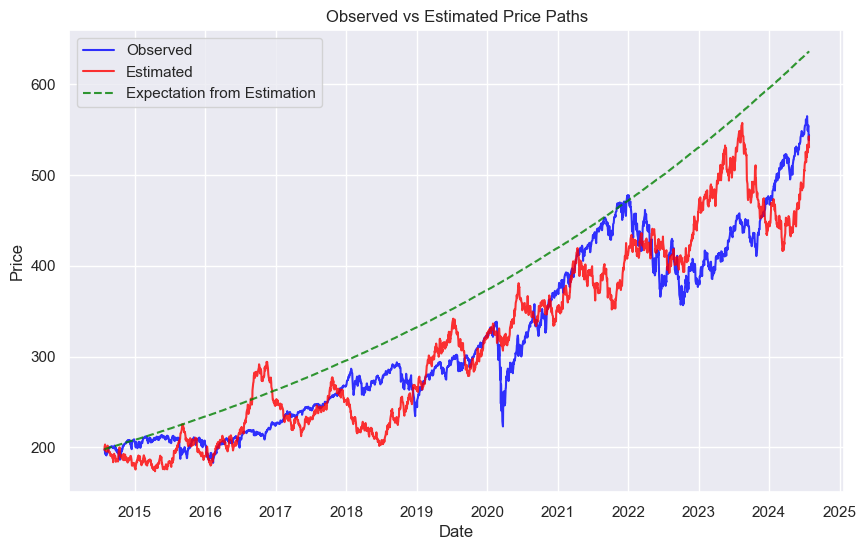

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(df_spy['date'], df_spy['close'], label='Observed', color='blue', alpha=0.8)
plt.plot(df_spy['date'], estimated_prices.values, label='Estimated', color='red', alpha=0.8)
plt.plot(df_spy['date'], expectation_return, label='Expectation from Estimation', color='green',linestyle='--', alpha=0.8)

plt.title('Observed vs Estimated Price Paths')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## ML for price prediction

### Gradiant Boosting

#### Regression

In [18]:
# Data import
data = yf.download('VOO', start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))
data = data.reset_index()
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
print(data.shape)
data.head()

[*********************100%%**********************]  1 of 1 completed

(503, 6)


,open,high,low,close,adj close,volume
date,,,,,,
2022-07-26,362.119995,362.209991,358.450012,359.250000,347.976746,2987200
2022-07-27,362.489990,370.329987,362.220001,368.660004,357.091522,4500300
2022-07-28,369.420013,373.910004,365.980011,373.320007,361.605255,4345300
2022-07-29,374.730011,379.660004,373.929993,378.790009,366.903625,5246400
2022-08-01,376.119995,380.010010,375.440002,377.649994,365.799408,4421400


In [19]:
for lag in range(1, 8):
    data[f'Close_lag_{lag}'] = data['close'].shift(lag)
    data[f'Volume_lag_{lag}'] = data['volume'].shift(lag)

# Moving Averages (shift by 1 to avoid data leakage)
data['SMA_5'] = data['close'].rolling(window=5).mean().shift(1)
data['SMA_10'] = data['close'].rolling(window=10).mean().shift(1)
# data['SMA_20'] = data['close'].rolling(window=20).mean().shift(1) # same as data['Middle_Band']

data['EMA_5'] = data['close'].ewm(span=5, adjust=False).mean().shift(1)
data['EMA_10'] = data['close'].ewm(span=10, adjust=False).mean().shift(1)
data['EMA_20'] = data['close'].ewm(span=20, adjust=False).mean().shift(1)

# Relative Strength Index (RSI)
delta = data['close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean().shift(1)
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean().shift(1)
rs = gain / loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# Bollinger Bands
data['Middle_Band'] = data['close'].rolling(window=20).mean().shift(1)
data['Upper_Band'] = data['Middle_Band'] + 2 * data['close'].rolling(window=20).std().shift(1)
data['Lower_Band'] = data['Middle_Band'] - 2 * data['close'].rolling(window=20).std().shift(1)

# Volume-based features
data['Volume_SMA_5'] = data['volume'].rolling(window=5).mean().shift(1)
data['Volume_SMA_10'] = data['volume'].rolling(window=10).mean().shift(1)
data['Volume_SMA_20'] = data['volume'].rolling(window=20).mean().shift(1)

# Date features
data['Day_of_Week'] = data.index.dayofweek
data['Month'] = data.index.month

# Drop rows with NaN values generated by rolling and shifting operations
data.dropna(inplace=True)
print(data.shape)
data.head()

(483, 34)


,open,high,low,close,adj close,volume,Close_lag_1,Volume_lag_1,Close_lag_2,Volume_lag_2,...,EMA_20,RSI_14,Middle_Band,Upper_Band,Lower_Band,Volume_SMA_5,Volume_SMA_10,Volume_SMA_20,Day_of_Week,Month
date,,,,,,,,,,,,,,,,,,,,,
2022-08-23,379.559998,381.869995,378.519989,379.040009,367.145752,2869200,379.940002,4153700.0,388.119995,2899000.0,...,382.002853,55.473284,382.030502,400.523722,363.537282,3479580.0,3385310.0,3652730.0,1,8
2022-08-24,378.899994,381.579987,378.179993,380.190002,368.259674,2241200,379.040009,2869200.0,379.940002,4153700.0,...,381.720678,47.346405,383.020003,398.202442,367.837563,3280460.0,3436180.0,3646830.0,2,8
2022-08-25,381.760010,385.730011,380.700012,385.730011,373.625854,2631300,380.190002,2241200.0,379.040009,2869200.0,...,381.574899,49.258328,383.596503,397.285207,369.907798,3084240.0,3295200.0,3533875.0,3,8
2022-08-26,385.549988,386.049988,372.510010,372.510010,360.820648,5153200,385.730011,2631300.0,380.190002,2241200.0,...,381.970624,56.556446,384.217003,397.042168,371.391838,2958880.0,3200790.0,3448175.0,4,8
2022-08-29,369.769989,373.049988,368.779999,370.049988,358.437836,4953200,372.510010,5153200.0,385.730011,2631300.0,...,381.069613,43.715841,383.903003,397.567653,370.238353,3409720.0,3349670.0,3443515.0,0,8


In [20]:
features = data.drop(columns=['close', 'open', 'high', 'low', 'adj close', 'volume'])
print(features.shape)
print(features.isna().sum())
target = data['close']
print(target.shape)
print(target.isna().sum())


(483, 28)
Close_lag_1      0
Volume_lag_1     0
Close_lag_2      0
Volume_lag_2     0
Close_lag_3      0
Volume_lag_3     0
Close_lag_4      0
Volume_lag_4     0
Close_lag_5      0
Volume_lag_5     0
Close_lag_6      0
Volume_lag_6     0
Close_lag_7      0
Volume_lag_7     0
SMA_5            0
SMA_10           0
EMA_5            0
EMA_10           0
EMA_20           0
RSI_14           0
Middle_Band      0
Upper_Band       0
Lower_Band       0
Volume_SMA_5     0
Volume_SMA_10    0
Volume_SMA_20    0
Day_of_Week      0
Month            0
dtype: int64
(483,)
0


In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a GBM model
import xgboost as xgb
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_train, model.predict(X_train))
print(f'Mean Squared Error, train: {mse}')
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error, test: {mse}')

Mean Squared Error, train: 0.8209134357368545
Mean Squared Error, test: 20.955452951055367


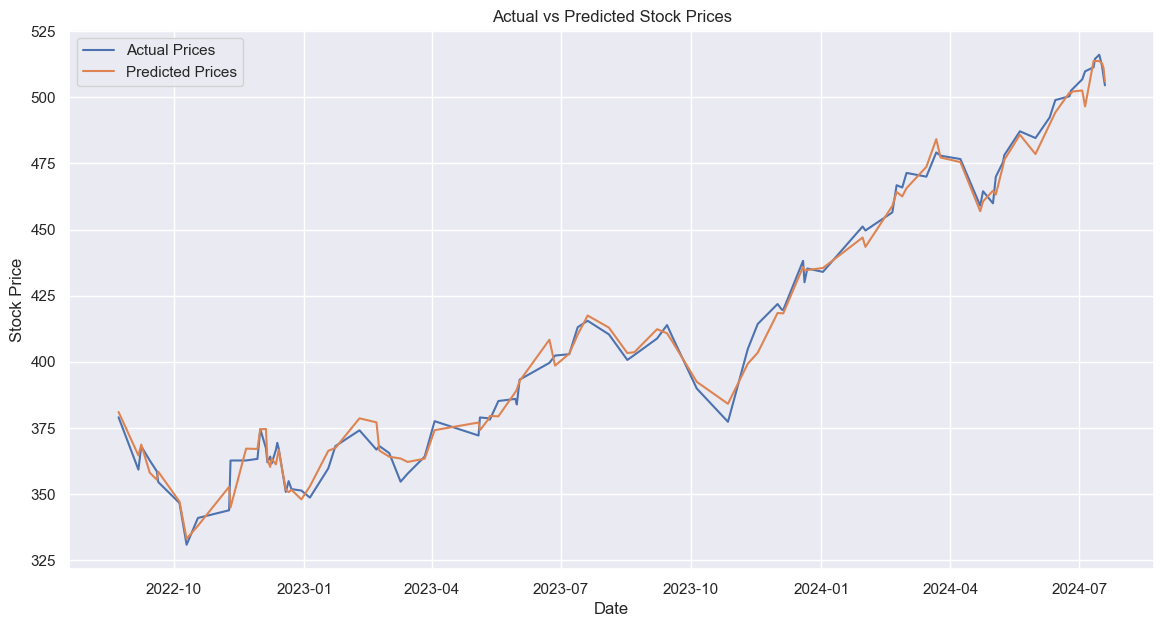

In [22]:
df_plot = pd.DataFrame()
df_plot['date'] = y_test.index
df_plot['actual'] = y_test.tolist()
df_plot['pred'] = predictions
df_plot.sort_values(by='date',inplace=True)
plt.figure(figsize=(14, 7))
plt.plot(df_plot['date'] , df_plot['actual'] , label='Actual Prices')
plt.plot(df_plot['date'] , df_plot['pred'] , label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()


<Axes: title={'center': 'Feature Importance'}, xlabel='F score', ylabel='Features'>

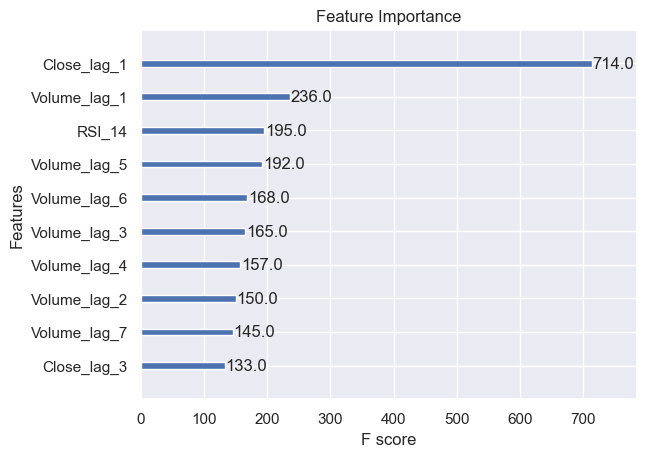

In [23]:
xgb.plot_importance(model, importance_type='weight', max_num_features=10, title='Feature Importance')

Build size: 434
OOT size: 49
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 150, 'subsample': 1.0}
Best cross-validation score (MSE): 225.91649560261848
Mean Squared Error on Out-of-Time Test Set: 602.4927799202958


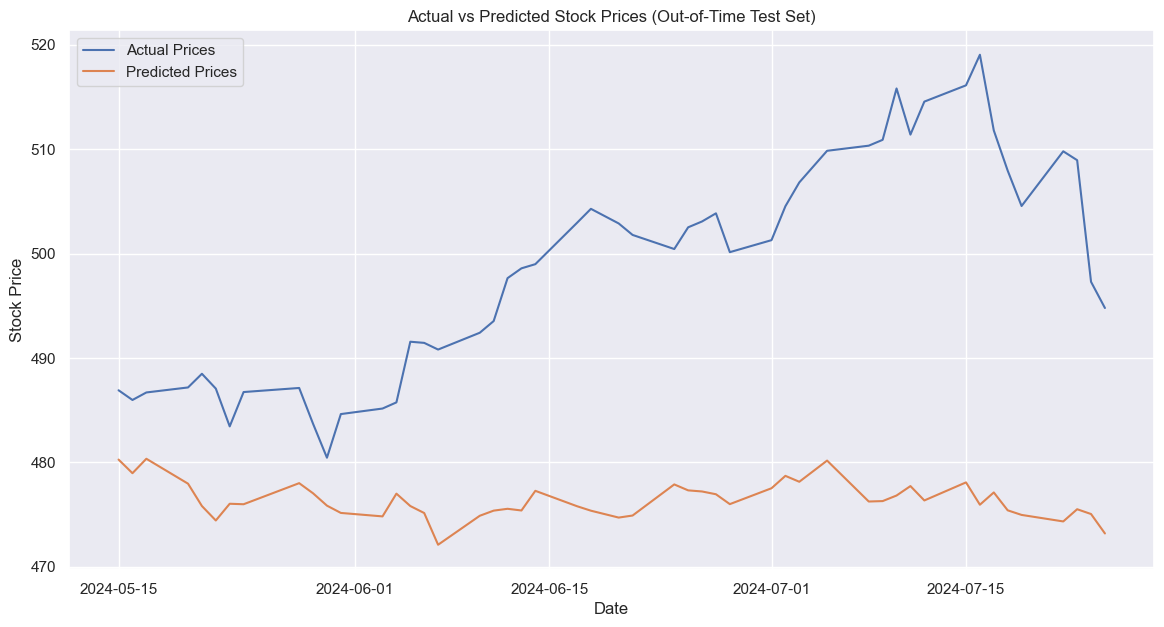

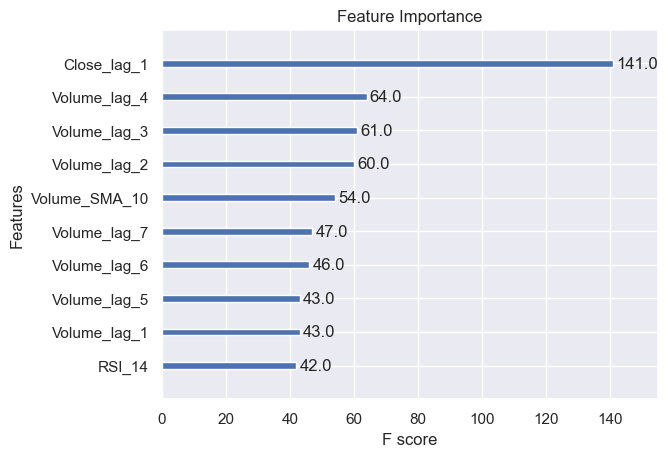

In [24]:
X_build, X_oot, y_build, y_oot = train_test_split(data.drop(columns=['close', 'open', 'high', 'low', 'adj close', 'volume']), 
                                                  data['close'], 
                                                  test_size=0.1, 
                                                  shuffle=False)
print('Build size:', len(y_build))
print('OOT size:', len(y_oot))

# Fine-tune the model using GridSearchCV with 5-fold cross-validation
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

grid_search.fit(X_build, y_build)

# Report cross-validation model performance
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation score (MSE): {-grid_search.best_score_}')

# Apply the optimal model to the out-of-time test set
optimal_model = grid_search.best_estimator_
y_oot_pred = optimal_model.predict(X_oot)

# Evaluate the model on the out-of-time test set
oot_mse = mean_squared_error(y_oot, y_oot_pred)
print(f'Mean Squared Error on Out-of-Time Test Set: {oot_mse}')

# Plotting y_oot and y_oot_pred
plt.figure(figsize=(14, 7))
plt.plot(y_oot.index, y_oot, label='Actual Prices')
plt.plot(y_oot.index, y_oot_pred, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices (Out-of-Time Test Set)')
plt.legend()
plt.show()

# Plot feature importance
xgb.plot_importance(optimal_model, importance_type='weight', max_num_features=10, title='Feature Importance')
plt.show()

#### Classification

In [25]:
# Data import
data = yf.download('VOO', start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))
data = data.reset_index()
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
print(data.shape)
data.head()

[*********************100%%**********************]  1 of 1 completed

(503, 6)


,open,high,low,close,adj close,volume
date,,,,,,
2022-07-26,362.119995,362.209991,358.450012,359.250000,347.976746,2987200
2022-07-27,362.489990,370.329987,362.220001,368.660004,357.091522,4500300
2022-07-28,369.420013,373.910004,365.980011,373.320007,361.605255,4345300
2022-07-29,374.730011,379.660004,373.929993,378.790009,366.903625,5246400
2022-08-01,376.119995,380.010010,375.440002,377.649994,365.799408,4421400


In [26]:
# create binary target: if the stock price goes 3% higher or more in the next 20 days then 1, otherwise 0 
data['Max_Close_Next_20_Days'] = data['close'].rolling(window=20, min_periods=1).max().shift(-20)
data['target'] = np.where(data['Max_Close_Next_20_Days'] >= data['close'] * 1.03, 1, 0)
data.dropna(subset=['Max_Close_Next_20_Days'], inplace=True)
print(data.shape)
data['target'].tail(21)

(483, 8)


date
2024-05-28    1
2024-05-29    1
2024-05-30    1
2024-05-31    1
2024-06-03    1
2024-06-04    1
2024-06-05    1
2024-06-06    1
2024-06-07    1
2024-06-10    1
2024-06-11    1
2024-06-12    1
2024-06-13    1
2024-06-14    1
2024-06-17    1
2024-06-18    0
2024-06-20    1
2024-06-21    1
2024-06-24    1
2024-06-25    1
2024-06-26    1
Name: target, dtype: int64

In [27]:
# features
for lag in range(1, 8):
    data[f'Close_lag_{lag}'] = data['close'].shift(lag)
    data[f'Volume_lag_{lag}'] = data['volume'].shift(lag)

# Moving Averages (shift by 1 to avoid data leakage)
data['SMA_5'] = data['close'].rolling(window=5).mean().shift(1)
data['SMA_10'] = data['close'].rolling(window=10).mean().shift(1)
# data['SMA_20'] = data['close'].rolling(window=20).mean().shift(1) # same as data['Middle_Band']

data['EMA_5'] = data['close'].ewm(span=5, adjust=False).mean().shift(1)
data['EMA_10'] = data['close'].ewm(span=10, adjust=False).mean().shift(1)
data['EMA_20'] = data['close'].ewm(span=20, adjust=False).mean().shift(1)

# Relative Strength Index (RSI)
delta = data['close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean().shift(1)
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean().shift(1)
rs = gain / loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# Bollinger Bands
data['Middle_Band'] = data['close'].rolling(window=20).mean().shift(1)
data['Upper_Band'] = data['Middle_Band'] + 2 * data['close'].rolling(window=20).std().shift(1)
data['Lower_Band'] = data['Middle_Band'] - 2 * data['close'].rolling(window=20).std().shift(1)

# Volume-based features
data['Volume_SMA_5'] = data['volume'].rolling(window=5).mean().shift(1)
data['Volume_SMA_10'] = data['volume'].rolling(window=10).mean().shift(1)
data['Volume_SMA_20'] = data['volume'].rolling(window=20).mean().shift(1)

# Date features
data['Day_of_Week'] = data.index.dayofweek
data['Month'] = data.index.month

# Drop rows with NaN values generated by rolling and shifting operations
data.dropna(inplace=True)
print(data.shape)
data.head()

(463, 36)


,open,high,low,close,adj close,volume,Max_Close_Next_20_Days,target,Close_lag_1,Volume_lag_1,...,EMA_20,RSI_14,Middle_Band,Upper_Band,Lower_Band,Volume_SMA_5,Volume_SMA_10,Volume_SMA_20,Day_of_Week,Month
date,,,,,,,,,,,,,,,,,,,,,
2022-08-23,379.559998,381.869995,378.519989,379.040009,367.145752,2869200,385.730011,0,379.940002,4153700.0,...,382.002853,55.473284,382.030502,400.523722,363.537282,3479580.0,3385310.0,3652730.0,1,8
2022-08-24,378.899994,381.579987,378.179993,380.190002,368.259674,2241200,385.730011,0,379.040009,2869200.0,...,381.720678,47.346405,383.020003,398.202442,367.837563,3280460.0,3436180.0,3646830.0,2,8
2022-08-25,381.760010,385.730011,380.700012,385.730011,373.625854,2631300,377.859985,0,380.190002,2241200.0,...,381.574899,49.258328,383.596503,397.285207,369.907798,3084240.0,3295200.0,3533875.0,3,8
2022-08-26,385.549988,386.049988,372.510010,372.510010,360.820648,5153200,377.859985,0,385.730011,2631300.0,...,381.970624,56.556446,384.217003,397.042168,371.391838,2958880.0,3200790.0,3448175.0,4,8
2022-08-29,369.769989,373.049988,368.779999,370.049988,358.437836,4953200,377.859985,0,372.510010,5153200.0,...,381.069613,43.715841,383.903003,397.567653,370.238353,3409720.0,3349670.0,3443515.0,0,8


In [28]:
features = data.drop(columns=['close', 'open', 'high', 'low', 'adj close', 'volume', 'Max_Close_Next_20_Days', 'target'])
print(features.shape)
print(features.isna().sum())
target = data['target']
print(target.shape)
print(target.isna().sum())

(463, 28)
Close_lag_1      0
Volume_lag_1     0
Close_lag_2      0
Volume_lag_2     0
Close_lag_3      0
Volume_lag_3     0
Close_lag_4      0
Volume_lag_4     0
Close_lag_5      0
Volume_lag_5     0
Close_lag_6      0
Volume_lag_6     0
Close_lag_7      0
Volume_lag_7     0
SMA_5            0
SMA_10           0
EMA_5            0
EMA_10           0
EMA_20           0
RSI_14           0
Middle_Band      0
Upper_Band       0
Lower_Band       0
Volume_SMA_5     0
Volume_SMA_10    0
Volume_SMA_20    0
Day_of_Week      0
Month            0
dtype: int64
(463,)
0


<Axes: ylabel='Frequency'>

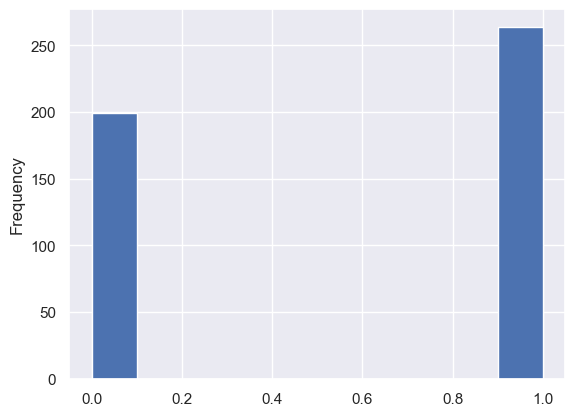

In [29]:
data['target'].plot(kind='hist')

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a GBM model
import xgboost as xgb
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', n_estimators=100, learning_rate=0.05)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate accuracy and AUC-ROC score
precision = precision_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print(f'Precision on test set: {precision:.4f}')
print(f'AUC-ROC score on test set: {auc_roc:.4f}')
print(f'F1 score on test set: {f1:.4f}')

Precision on test set: 0.8276
AUC-ROC score on test set: 0.9057
F1 score on test set: 0.8807


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/opt/anaconda3/envs/ts_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ts_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ts_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ts_en

Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Best cross-validation score (AUC): 0.8040572877602772
Precision on test set: 0.5139
AUC-ROC score on test set: 0.3857
F1 score on test set: 0.5736


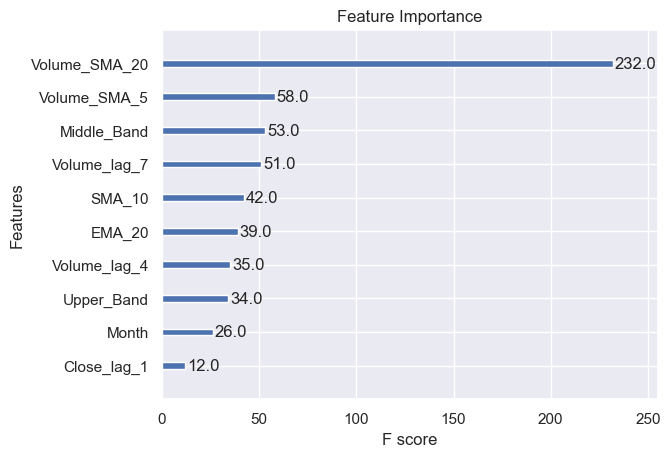

In [31]:
X_build, X_oot, y_build, y_oot = train_test_split(features, target, test_size=0.2, shuffle=False)

# Fine-tune the model using GridSearchCV with 5-fold cross-validation
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = xgb.XGBClassifier(objective='binary:logistic')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=1)

grid_search.fit(X_build, y_build)

# Report cross-validation model performance
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation score (AUC): {grid_search.best_score_}')

# Apply the optimal model to the out-of-time test set
optimal_model = grid_search.best_estimator_
y_oot_pred = optimal_model.predict(X_oot)
y_oot_pred_proba = optimal_model.predict_proba(X_oot)[:, 1]

# Calculate accuracy and AUC-ROC score
f1 = f1_score(y_oot, y_oot_pred)
precision = precision_score(y_oot, y_oot_pred)
auc_roc = roc_auc_score(y_oot, y_oot_pred_proba)

print(f'Precision on test set: {precision:.4f}')
print(f'AUC-ROC score on test set: {auc_roc:.4f}')
print(f'F1 score on test set: {f1:.4f}')

# Plot feature importance
xgb.plot_importance(optimal_model, importance_type='weight', max_num_features=10, title='Feature Importance')
plt.show()

### LSTM

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Data import
data = yf.download('VOO', start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))
data = data.reset_index()
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
print(data.shape)
data.head()

[*********************100%%**********************]  1 of 1 completed

(503, 6)


,open,high,low,close,adj close,volume
date,,,,,,
2022-07-26,362.119995,362.209991,358.450012,359.250000,347.976746,2987200
2022-07-27,362.489990,370.329987,362.220001,368.660004,357.091522,4500300
2022-07-28,369.420013,373.910004,365.980011,373.320007,361.605255,4345300
2022-07-29,374.730011,379.660004,373.929993,378.790009,366.903625,5246400
2022-08-01,376.119995,380.010010,375.440002,377.649994,365.799408,4421400


In [33]:
# create binary target: if the stock price goes 3% higher or more in the next 20 days then 1, otherwise 0 
data['Max_Close_Next_20_Days'] = data['close'].rolling(window=20, min_periods=1).max().shift(-20)
data['target'] = np.where(data['Max_Close_Next_20_Days'] >= data['close'] * 1.03, 1, 0)
data.dropna(subset=['Max_Close_Next_20_Days'], inplace=True)
print(data.shape)
data['target'].tail(21)

(483, 8)


date
2024-05-28    1
2024-05-29    1
2024-05-30    1
2024-05-31    1
2024-06-03    1
2024-06-04    1
2024-06-05    1
2024-06-06    1
2024-06-07    1
2024-06-10    1
2024-06-11    1
2024-06-12    1
2024-06-13    1
2024-06-14    1
2024-06-17    1
2024-06-18    0
2024-06-20    1
2024-06-21    1
2024-06-24    1
2024-06-25    1
2024-06-26    1
Name: target, dtype: int64

## ML for top / bottom identification

In [16]:
stock_name = 'voo'
stg = stock_strategy(stock_name, start='2020-04-01')
df = stg.df
df.head()

[*********************100%***********************]  1 of 1 completed


Price,date,close,high,low,open,volume,5 Day EMA,12 Day EMA,26 Day EMA,50 Day EMA,...,50 Day MA,Upper Band - 50MA,Lower Band - 50MA,120 Day MA,200 Day MA,RSI_raw,RSI,MACD,MACD_signal,MACD_diff
0,2020-04-01,208.262604,212.775045,206.402386,209.892609,13710100,208.262604,208.262604,208.262604,208.262604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,2020-04-02,213.134201,213.815662,206.945720,207.507472,6547000,209.886470,209.012080,208.623463,208.453647,...,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.388617,0.077723,0.310894
2,2020-04-03,209.984726,214.303772,207.516694,212.204096,5490200,209.919222,209.161718,208.724297,208.513689,...,NaN,NaN,NaN,NaN,NaN,NaN,58.954339,0.437421,0.149663,0.287758
3,2020-04-06,224.267960,225.897965,217.269077,218.217622,7624000,214.702134,211.485755,209.875680,209.131504,...,NaN,NaN,NaN,NaN,NaN,NaN,86.339324,1.610076,0.441746,1.168330
4,2020-04-07,224.387634,232.804702,224.203456,231.994302,12936600,217.930634,213.470660,210.950639,209.729783,...,NaN,NaN,NaN,NaN,NaN,NaN,86.421071,2.520021,0.857401,1.662620


In [48]:
# label: 
# for top: 
# simple: drop more than 5% after 10days
# complex: the minimal price of the next 10days drop more than 5% comparing to the current price
# for bottom: 
# simple: increase more than 5% after 10days
# complex: the maximal price of the next 10days increases more than 5% comparing to the current price
df['label_tops'] = 1*((df['close'].shift(-10) / df['close'] - 1) < -0.05)
df['label_bottoms'] = 1*((df['close'].shift(-10) / df['close'] - 1) > 0.05)
df['label_topc'] = 1*(df[::-1]['close'].shift(1).rolling(window=10).min()[::-1] / df['close'] - 1 < -0.05)
df['label_bottomc'] = 1*(df[::-1]['close'].shift(1).rolling(window=10).max()[::-1] / df['close'] - 1 > 0.05)
df.groupby(['label_topc', 'label_tops', 'label_bottomc', 'label_bottoms']).size()

label_topc  label_tops  label_bottomc  label_bottoms
0           0           0              0                1164
                        1              0                  46
                                       1                  82
1           0           0              0                  43
            1           0              0                  64
dtype: int64